# Segmenting and Clustering Neighborhoods in Toronto
### Part 2

## Section 3.2 - Analysis and clustering

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

### Load our work from part 1

In [2]:
path = os.path.join(os.path.abspath('../data'), 'TorontoVenues.csv')
venues_df = pd.read_csv(path)
venues_df.head()

,Neighborhood,Neighborhood_lat,Neighborhood_long,Venue,Category,Venue_lat,Venue_long
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park,43.751976,-79.332140
1,Parkwoods,43.753259,-79.329656,Sun Life,Construction & Landscaping,43.754760,-79.332783
2,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop,43.751974,-79.333114
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,Hockey Arena,43.723481,-79.315635
4,Victoria Village,43.725882,-79.315572,Portugril,Portuguese Restaurant,43.725819,-79.312785


### Calculate the proportions of venue categories in each neighborhood

One way to do this is to one_hot code the venue categories for each neighborhood. From that we can calculate what proportions of each type of venue is found in each neighborhood. 

In [3]:
# One hot encode the venue categories for each neighborhood
venues_onehot = pd.get_dummies(venues_df['Category'], prefix='', prefix_sep='')

# Add the neighborhood column to the new dataframe
venues_onehot['Neighborhood'] = venues_df['Neighborhood']

# Pandas added the new column alphabetically, so find out where it is and move it
# to be the first column
cols = list(venues_onehot.columns)
index = cols.index('Neighborhood')
fixed_columns = [venues_onehot.columns[index]] + cols[:index] + cols[index + 1:]
venues_onehot = venues_onehot[fixed_columns]

# Now we can calculate the proportions by getting the means of each category
venues_grouped = venues_onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped.head()

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


If we sum all frequencies of venues for each neighborhood, is it aproximately 1? Just look at the first five to verify this assumption.

In [4]:
totals = []
for index, row in venues_grouped.iterrows():
    if index > 4:
        break
    totals.append({'Neighborhood': row['Neighborhood'],
                   'Sum': row[1:].sum()})
pd.DataFrame(totals)
    

,Neighborhood,Sum
0,Agincourt,1.0
1,"Alderwood, Long Branch",1.0
2,"Bathurst Manor, Wilson Heights, Downsview North",1.0
3,Bayview Village,1.0
4,"Bedford Park, Lawrence Manor East",1.0


We can identify the top 10 venue types for each neighborhood. We will also include the significance of each of type, as its 'weight.' This is just the percentage of listed venue types for the neighborhood. It will also show categories that actually do not occur for a neighborhood with fewer venue types than num_venues.

We can adapt the function to generate the row with the top num_venues venue types along with their weights. As a dictionary it is simple to assemble them into a dataframe.

In [5]:
def mostCommon(row, num_venues):
    row_cats = row.iloc[1:]
    row_cats_sorted = row_cats.sort_values(ascending=False)
    row = {'Neighborhood': row.iloc[0]}
    for i in range(num_venues):
        row[f'Top_{i + 1}'] = row_cats_sorted.index[i]
        row[f'Weight_{i + 1}'] = round(row_cats_sorted[i], 2)
    return row

Assemble the dataframe

In [6]:
num_venues = 10
rows = []
for i in range(venues_grouped.shape[0]):
    rows.append(mostCommon(venues_grouped.iloc[i], num_venues))
top_venues = pd.DataFrame(rows)  

top_venues.head()     

,Neighborhood,Top_1,Weight_1,Top_2,Weight_2,Top_3,Weight_3,Top_4,Weight_4,Top_5,...,Top_6,Weight_6,Top_7,Weight_7,Top_8,Weight_8,Top_9,Weight_9,Top_10,Weight_10
0,Agincourt,Skating Rink,0.25,Lounge,0.25,Breakfast Spot,0.25,Latin American Restaurant,0.25,Mexican Restaurant,...,Molecular Gastronomy Restaurant,0.00,Modern European Restaurant,0.00,Mobile Phone Shop,0.00,Miscellaneous Shop,0.00,Middle Eastern Restaurant,0.00
1,"Alderwood, Long Branch",Pizza Place,0.25,Skating Rink,0.12,Coffee Shop,0.12,Pub,0.12,Sandwich Place,...,Pharmacy,0.12,Gym,0.12,Hobby Shop,0.00,Movie Theater,0.00,Men's Store,0.00
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,0.10,Bank,0.10,Ice Cream Shop,0.05,Fried Chicken Joint,0.05,Chinese Restaurant,...,Bridal Shop,0.05,Gas Station,0.05,Diner,0.05,Sandwich Place,0.05,Intersection,0.05
3,Bayview Village,Japanese Restaurant,0.25,Café,0.25,Bank,0.25,Chinese Restaurant,0.25,Motel,...,Moroccan Restaurant,0.00,Monument / Landmark,0.00,Molecular Gastronomy Restaurant,0.00,Modern European Restaurant,0.00,Accessories Store,0.00
4,"Bedford Park, Lawrence Manor East",Sushi Restaurant,0.09,Italian Restaurant,0.09,Coffee Shop,0.09,Sandwich Place,0.09,Butcher,...,Thai Restaurant,0.04,Indian Restaurant,0.04,Café,0.04,Restaurant,0.04,Juice Bar,0.04


In [7]:
top_venues.shape

(95, 21)

## Clustering the neighborhoods by venue types

In [8]:
KCLUSTERS = 5

kmeans = KMeans(KCLUSTERS, random_state=42)
kmeans.fit(venues_grouped.drop(columns=['Neighborhood']))

kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 3])

Not very compelling. Let's try an elbow plot to see if we can find an optimal value for K.

In [9]:
def calculate_scores(X, kmax):
    distortions = []
    for k in range(1, kmax+1):
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    return distortions

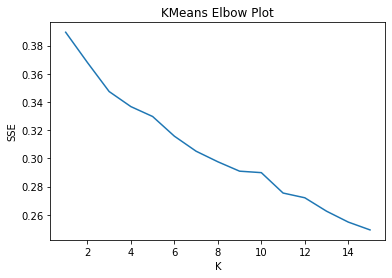

In [10]:
max_k = 15
sse = calculate_scores(venues_grouped.drop(columns=['Neighborhood']), max_k)

plt.plot(range(1, max_k + 1), sse)
plt.title('KMeans Elbow Plot')
plt.xlabel('K')
plt.ylabel('SSE')
plt.show()

It seems there is not an optimal level. As K gets higher, of course, it becomes closer to the number of neighborhhoods being segmented, and would become useless. Just trying K = 15.

In [11]:
KCLUSTERS = 15

kmeans = KMeans(KCLUSTERS, random_state=42)
kmeans.fit(venues_grouped.drop(columns=['Neighborhood']))

top_venues['Cluster'] = kmeans.labels_
new_columns = [top_venues.columns[-1]] + list(top_venues.columns[:-1])
top_venues = top_venues[new_columns]
top_venues.head()

,Cluster,Neighborhood,Top_1,Weight_1,Top_2,Weight_2,Top_3,Weight_3,Top_4,Weight_4,...,Top_6,Weight_6,Top_7,Weight_7,Top_8,Weight_8,Top_9,Weight_9,Top_10,Weight_10
0,5,Agincourt,Skating Rink,0.25,Lounge,0.25,Breakfast Spot,0.25,Latin American Restaurant,0.25,...,Molecular Gastronomy Restaurant,0.00,Modern European Restaurant,0.00,Mobile Phone Shop,0.00,Miscellaneous Shop,0.00,Middle Eastern Restaurant,0.00
1,3,"Alderwood, Long Branch",Pizza Place,0.25,Skating Rink,0.12,Coffee Shop,0.12,Pub,0.12,...,Pharmacy,0.12,Gym,0.12,Hobby Shop,0.00,Movie Theater,0.00,Men's Store,0.00
2,10,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,0.10,Bank,0.10,Ice Cream Shop,0.05,Fried Chicken Joint,0.05,...,Bridal Shop,0.05,Gas Station,0.05,Diner,0.05,Sandwich Place,0.05,Intersection,0.05
3,10,Bayview Village,Japanese Restaurant,0.25,Café,0.25,Bank,0.25,Chinese Restaurant,0.25,...,Moroccan Restaurant,0.00,Monument / Landmark,0.00,Molecular Gastronomy Restaurant,0.00,Modern European Restaurant,0.00,Accessories Store,0.00
4,10,"Bedford Park, Lawrence Manor East",Sushi Restaurant,0.09,Italian Restaurant,0.09,Coffee Shop,0.09,Sandwich Place,0.09,...,Thai Restaurant,0.04,Indian Restaurant,0.04,Café,0.04,Restaurant,0.04,Juice Bar,0.04


In [12]:
kmeans.labels_

array([ 5,  3, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10,  3,
        1, 10, 10,  3,  3, 10, 10, 10, 10,  4, 10, 10, 10, 11, 10, 11, 11,
       10, 10, 10, 10,  7,  2, 10, 10, 10, 10,  3, 10, 11, 10, 10,  9,  0,
       10, 10, 10, 11, 10, 10, 10,  2, 10,  3, 14, 10, 10, 10,  0,  8, 10,
       10,  3, 13,  3, 10, 10,  3, 10, 10, 10, 10, 10, 10,  6, 10, 10, 10,
        3, 12,  3,  4, 10, 10,  3,  3, 10, 14])